# Introduction to Data Science
## Homework 4 

Student Name: Ramya Dhatri Vunikili

Student Netid: rdv253
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [2]:
#Don't forget to import the packages you'll need here.
from sklearn import preprocessing
import pandas as pd
import numpy as np

def cleanBosonData(infile_name):
    # Code here
    data = pd.read_csv(infile_name, sep=',', index_col=0)
    s_count = (data[data['Label'] == 's']['Label'].count())
    b_count = (data[data['Label'] == 'b']['Label'].count())
    if (s_count < b_count):
        data['Y'] = data['Label'].map({'s': 1, 'b': 0})
    else:
        data['Y'] = data['Label'].map({'b': 1, 's': 0})
    data.drop('Label',1, inplace = True)
    for column in data:
        if (-999 in data[column].values):
            data[column+'_mv'] = data[column].replace(-999,1)
            mean = data[column].replace(-999, np.nan).mean()
            data[column] = data[column].replace(-999, mean)
    data_without_y = data.drop('Y',1)
    data_clean = preprocessing.StandardScaler().fit_transform(data_without_y)
    data_clean = pd.DataFrame(data_clean, columns = data_without_y.columns)
    data = data.reset_index(drop=True)
    data_clean = data_clean.reset_index(drop=True)
    data_clean['Y'] = data['Y'].values
    return data_clean

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [3]:
#Student put code here
dataDir = r'C:/Ramya Dhatri/Intro To Data Science/Assignments/4/'
data_train = cleanBosonData(dataDir + 'boson_training_cut_2000.csv')
data_test = cleanBosonData(dataDir + 'boson_testing_cut.csv')

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

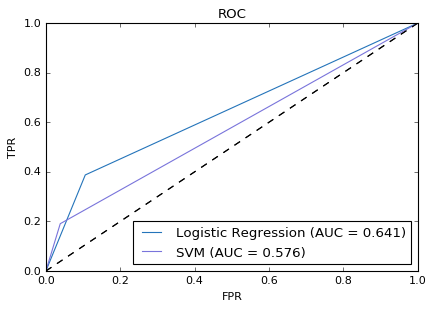

In [7]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model, svm
from sklearn.metrics import roc_curve, auc
import math
%matplotlib inline

# Code here
target = 'Y'
X_train = data_train.drop(target,1)
Y_train = data_train[target]
X_test = data_test.drop(target,1)
Y_test = data_test[target]

logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(X_train, Y_train)
pred_logreg = logreg.predict(X_test)

svmMod = svm.SVC(kernel='linear').fit(X_train, Y_train)
pred_svm = svmMod.predict(X_test)

def plotROC(preds, label_string):
    fpr, tpr, thresholds = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    return roc_auc

auc_dict = {}
auc_dict['logreg'] = plotROC(pred_logreg, 'Logistic Regression')
auc_dict['svm'] = plotROC(pred_svm, 'SVM')
fig = plt.figure(figsize = (12, 6))
#ax = fig.add_subplot(111)

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Logistic regression performs slightly better than SVM since it's AUC is relatively higher. In the range where FPR is approximately 0.1, SVM seems to have performed better. But the curves rapidly change beyond FPR = 0.1. Logistic regression shows a drastic change for FPR > 0.1 with a total AUC of 0.641.

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.cross_validation.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [10]:
#Don't forget to import any relevant libraries (i.e., sklearn.cross_validation)
from sklearn.cross_validation import *
from sklearn.metrics import roc_auc_score

def xValSVM(dataset, label_name, k, cs):
    # Code here
    aucs = {}
    for fold in range(2,k):
        cv = KFold(n = dataset.shape[0], n_folds = fold)
        for train_index, test_index in cv:
            cv_train = dataset.iloc[train_index]
            cv_validate = dataset.iloc[test_index]
            for c in cs:
                svmMod = svm.SVC(kernel='linear', C=c).fit(cv_train.drop(label_name,1), cv_train[label_name])
                pred_svm = svmMod.predict(cv_validate.drop(label_name, 1))
                score = roc_auc_score(cv_validate[label_name], pred_svm)
                if c in aucs:
                    aucs[c].append(score)
                else:
                    aucs[c] = [score]
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [11]:
cs = []
for exp in range(-8,2):
    cs.append(10**exp)
aucs = xValSVM(data_train,'Y', 10, cs)
#print aucs

In [12]:
c_stats_dict = {}
for c in cs:
    auc_stat_dict = {}
    auc_list = aucs[c]
    mean = np.mean(auc_list)
    stdErr = np.var(auc_list)/len(auc_list)
    term1 = mean - (2*stdErr)
    term2 = mean + (2*stdErr)
    max_1std = mean - stdErr
    auc_stat_dict = {'mean':mean, 'term1':term1, 'term2':term2, 'max':max_1std}
    c_stats_dict[c] = auc_stat_dict
    
#print c_stats_dict

10


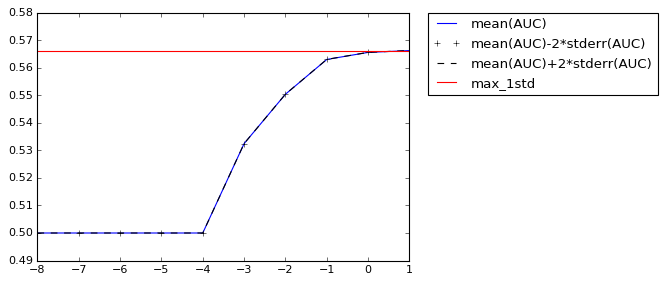

In [19]:
c_val_for_max_mean = max(c_stats_dict, key=lambda v: c_stats_dict[v]['mean'])
max_1std = c_stats_dict[c_val_for_max_mean]['max']
print c_val_for_max_mean
mean = []
term1 = []
term2 = []
for c in range(-8,2):
    powerC= 10**c
    mean.append(c_stats_dict[powerC]['mean'])
    term1.append(c_stats_dict[powerC]['term1'])
    term2.append(c_stats_dict[powerC]['term2'])
max_1std_list = [max_1std] * 10
X =[-8,-7,-6,-5,-4,-3,-2,-1,0,1]
plt.plot(X, mean, label = 'mean(AUC)')
plt.plot(X, term1, 'k+', label = 'mean(AUC)-2*stderr(AUC)')
plt.plot(X, term2, 'k--', label = 'mean(AUC)+2*stderr(AUC)')
plt.plot(X, max_1std_list, color = 'r', label = 'max_1std')
plt.autoscale()
plt.ylim([0.49, 0.58])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Yes. It can be observed from the graph that the mean(AUC) for c value at 1 standard error rule is the maximum. Also, the new value for c at 1 standard error rule is observed to be 10.

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [14]:
# Code here
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucs = []
    for run in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size=sampsize)]
        pred = pd.DataFrame()
        if (lr == 1):
            logreg = linear_model.LogisticRegression()
            logreg.fit(train_samp.drop('Y',1), train_samp['Y'])
            pred = logreg.predict(test.drop('Y',1))
        else:
            svmMod = svm.SVC(kernel='linear', C=c).fit(train_samp.drop('Y',1), train_samp['Y'])
            pred = svmMod.predict(test.drop('Y',1))
        
        aucs.append(roc_auc_score(test['Y'],pred))
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [15]:
#Code here
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
aucs_lr = {}
aucs_svm = {}
for sample in samplesizes:
    auc1 = modBootstrapper(data_train, data_test, 20, sample, 1, 'default')
    auc2 = modBootstrapper(data_train, data_test, 20, sample, 0, c_val_for_max_mean)
    aucs_lr[sample] = auc1
    aucs_svm[sample] = auc2

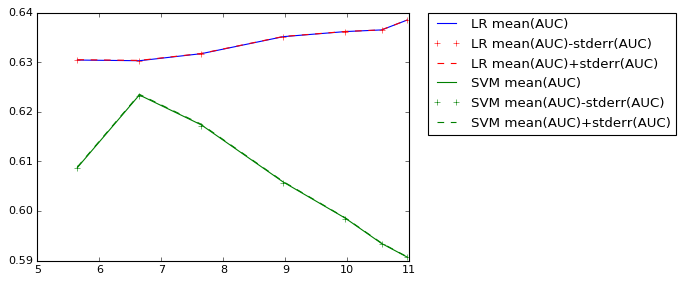

In [18]:
def calculateAUCStats(samplesizes, lr):
    auc_stats = {}
    auc_list = []
    for sample in samplesizes:
        if (lr == 1):
            auc_list = aucs_lr[sample]
        else:
            auc_list = aucs_svm[sample]
        mean = np.mean(auc_list)
        stdErr = np.var(auc_list)/len(auc_list)
        term1 = mean - stdErr
        term2 = mean + stdErr
        auc_stats[sample] = {'mean':mean, 'term1':term1, 'term2':term2}
    return auc_stats

aucs_lr_stats = calculateAUCStats(samplesizes,1)
aucs_svm_stats = calculateAUCStats(samplesizes,0)

def seggregateStats(samplesizes, lr):
    mean = []
    term1 = []
    term2 = []
    stats = {}
    if (lr == 1):
        stats = aucs_lr_stats
    else:
        stats = aucs_svm_stats
    for sample in samplesizes:
        mean.append(stats[sample]['mean'])
        term1.append(stats[sample]['term1'])
        term2.append(stats[sample]['term2'])
    return [mean,term1,term2]

lr_seg_stats = seggregateStats(samplesizes, 1)
svm_seg_stats = seggregateStats(samplesizes, 0)

X = np.log2(samplesizes)
plt.plot(X, lr_seg_stats[0], label = 'LR mean(AUC)')
plt.plot(X, lr_seg_stats[1], 'r+', label = 'LR mean(AUC)-stderr(AUC)')
plt.plot(X, lr_seg_stats[2], 'r--', label = 'LR mean(AUC)+stderr(AUC)')
plt.plot(X, svm_seg_stats[0], label = 'SVM mean(AUC)')
plt.plot(X, svm_seg_stats[1], 'g+', label = 'SVM mean(AUC)-stderr(AUC)')
plt.plot(X, svm_seg_stats[2], 'g--', label = 'SVM mean(AUC)+stderr(AUC)')
plt.autoscale()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?

Logistic Regression, clearly, is a better fit for smaller sample sizes for this set of features.
Regarding the question about investing in more data, it entirely depends on how much performance increase can be observed with more data. Even if there is an increase in the performance of the model we need to re-emphasize on the question that does this increase actually justify the cost of investing in more data.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



In the above plot, the curve has a higher slope when the sample size is small and then the slope drastically changes for higher sample sizes. During cross validation, the accuracy reported is for a predictor that is being trained on (k-1)/k times less data points than the full training set, indicating that if the training set is small, the performance could be much smaller than what could be expected from using the full training set. Hence, corss-validation will be biased towards smaller sample sizes.